# NDVR: What does an inverted Yield Curve mean for upcoming interest rate movements

## Packages

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as web

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

## Collect Data

In [2]:
tickers = ["DGS1MO", "DGS10", "DGS2"]
end_date = dt.date.today()
start_date = dt.date(year = end_date.year - 100, month = 1, day = 1)
df_raw = web.DataReader(
    name = tickers,
    data_source = "fred",
    start = start_date,
    end = end_date)

In [3]:
df_prep = (df_raw.reset_index().rename(columns = {
  "DATE": "Date",
  "DGS1MO": "one_month",
  "DGS10": "ten_year",
  "DGS2": "two_year"}).
  melt(id_vars = "Date").
  dropna())

In [4]:
column_renamer = {
    "one_month": "1m Bill",
    "ten_year": "10y TSY",
    "two_year": "2y TSY"}

## 10y Treasury 1 Month Bill Comparison

In [5]:
df_1m_prep = (df_prep.query(
    "variable == ['ten_year', 'one_month']").
    pivot(index = "Date", columns = "variable", values = "value").
    dropna().
    assign(spread = lambda x: x.ten_year - x.one_month))

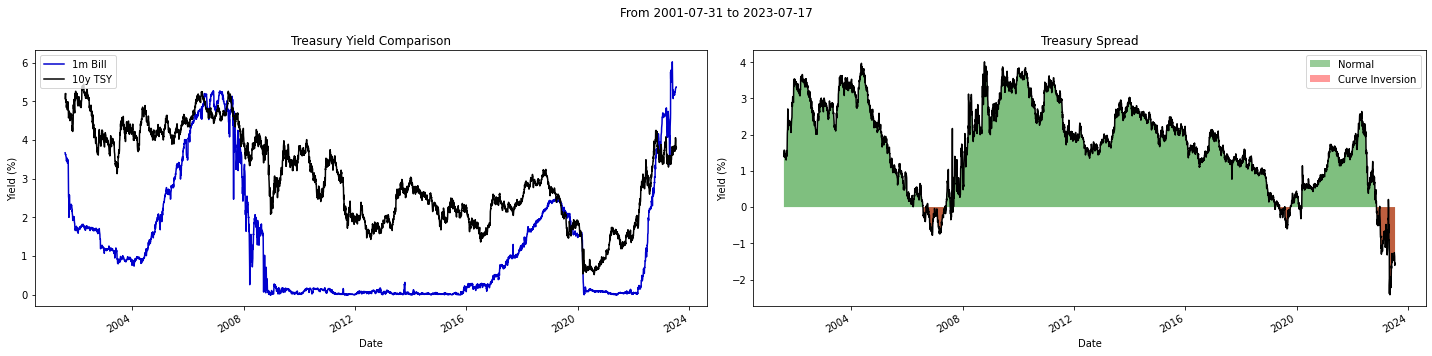

In [6]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

(df_1m_prep.drop(
    columns = ["spread"]).
    rename(columns = column_renamer).
    plot(
        ax = axes[0],
        ylabel = "Yield (%)",
        title = "Treasury Yield Comparison",
        color = ["mediumblue", "black"]))

(df_1m_prep[["spread"]].
    rename(columns = column_renamer).
    plot(
        ax = axes[1],
        ylabel = "Yield (%)",
        legend = False,
        title = "Treasury Spread",
        color = "black"))

axes[1].fill_between(
    x = df_1m_prep.index,
    y1 = df_1m_prep.spread,
    y2 = 0,
    facecolor = "green",
    alpha = 0.5)

axes[1].fill_between(
    x = df_1m_prep.index,
    y1 = df_1m_prep.spread,
    y2 = 0,
    where = df_1m_prep.spread < 0,
    facecolor = "red",
    alpha = 0.5)

legend_elements = [
    Patch(facecolor = "green", alpha = 0.4, label = "Normal"),
    Patch(facecolor = "red", alpha = 0.4, label = "Curve Inversion")]

axes[1].legend(handles = legend_elements)
axes[0].legend(loc = "upper left")

fig.suptitle("From {} to {}".format(
    df_1m_prep.index.min().date(),
    df_1m_prep.index.max().date()))

plt.tight_layout()

## 10y Treasury 2y Treasury Comparison

In [7]:
df_2y_prep = (df_prep.query(
    "variable == ['ten_year', 'two_year']").
    pivot(index = "Date", columns = "variable", values = "value").
    dropna().
    assign(spread = lambda x: x.ten_year - x.two_year))

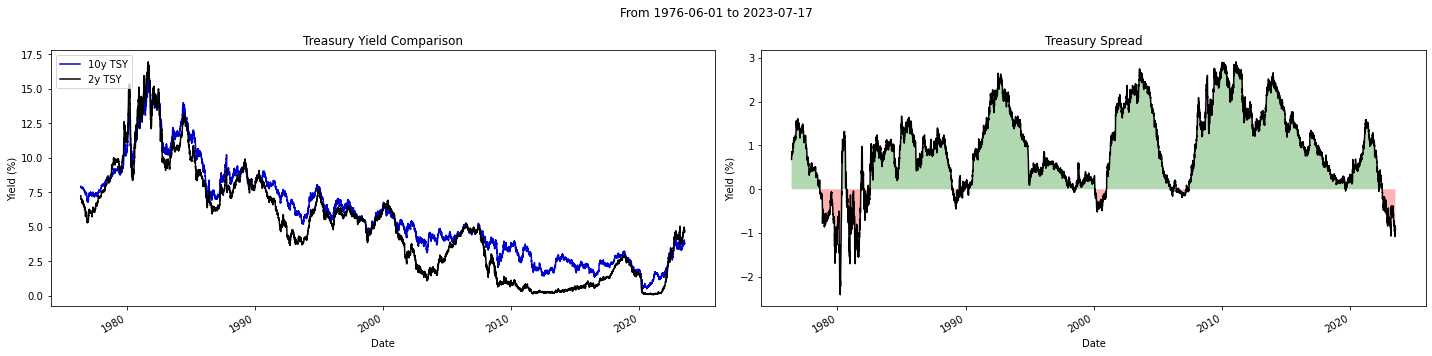

In [8]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

(df_2y_prep.drop(
    columns = ["spread"]).
    rename(columns = column_renamer).
    plot(
        ax = axes[0],
        ylabel = "Yield (%)",
        title = "Treasury Yield Comparison",
        color = ["mediumblue", "black"]))

(df_2y_prep[["spread"]].
    rename(columns = column_renamer).
    plot(
        ax = axes[1],
        ylabel = "Yield (%)",
        legend = False,
        title = "Treasury Spread",
        color = "black"))

axes[1].fill_between(
    x = df_2y_prep.index,
    y1 = df_2y_prep.spread,
    y2 = 0,
    where = df_2y_prep.spread > 0,
    facecolor = "green",
    alpha = 0.3)

axes[1].fill_between(
    x = df_2y_prep.index,
    y1 = df_2y_prep.spread,
    y2 = 0,
    where = df_2y_prep.spread < 0,
    facecolor = "red",
    alpha = 0.3)

axes[0].legend(loc = "upper left")
fig.suptitle("From {} to {}".format(
    df_2y_prep.index.min().date(),
    df_2y_prep.index.max().date()))

plt.tight_layout()

## Distribution Comparison

In [9]:
spread_list = [df_1m_prep, df_2y_prep]
names = ["10y TSY - 1m Bill", "10y TSY - 2y TSY"]

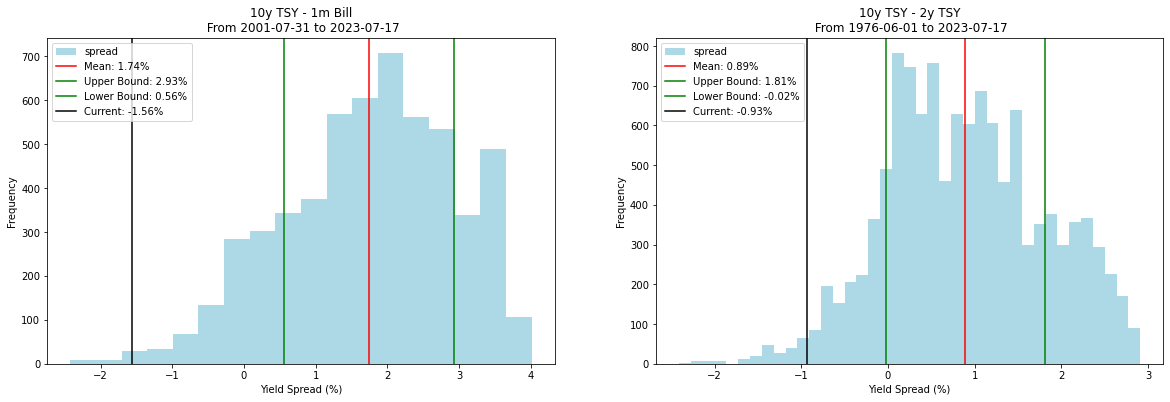

In [10]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))
for i, (df_spread, name) in enumerate(zip(spread_list, names)):

    df_tmp = df_spread["spread"]
    bins = int(len(df_tmp) / 300)

    mean, std = df_tmp.mean(), df_tmp.std()
    current_value = df_tmp.iloc[-1]
    title = name + "\n From {} to {}".format(
        df_spread.index.min().date(),
        df_spread.index.max().date())

    (df_tmp.plot(
        ax = axes[i],
        title = title,
        kind = "hist",
        bins = bins,
        color = "lightblue"))

    axes[i].axvline(
        x = mean,
        color = "r",
        label = "Mean: {}%".format(round(mean, 2)))

    axes[i].axvline(
        x = mean + std,
        color = "g",
        label = "Upper Bound: {}%".format(round(mean + std, 2)))

    axes[i].axvline(
        x = mean - std,
        color = "g",
        label = "Lower Bound: {}%".format(round(mean - std, 2)))

    axes[i].axvline(
        x = current_value,
        color = "black",
        label = "Current: {}%".format(round(current_value, 2)))

    axes[i].legend(loc = "upper left")
    axes[i].set_xlabel("Yield Spread (%)")

## Regression

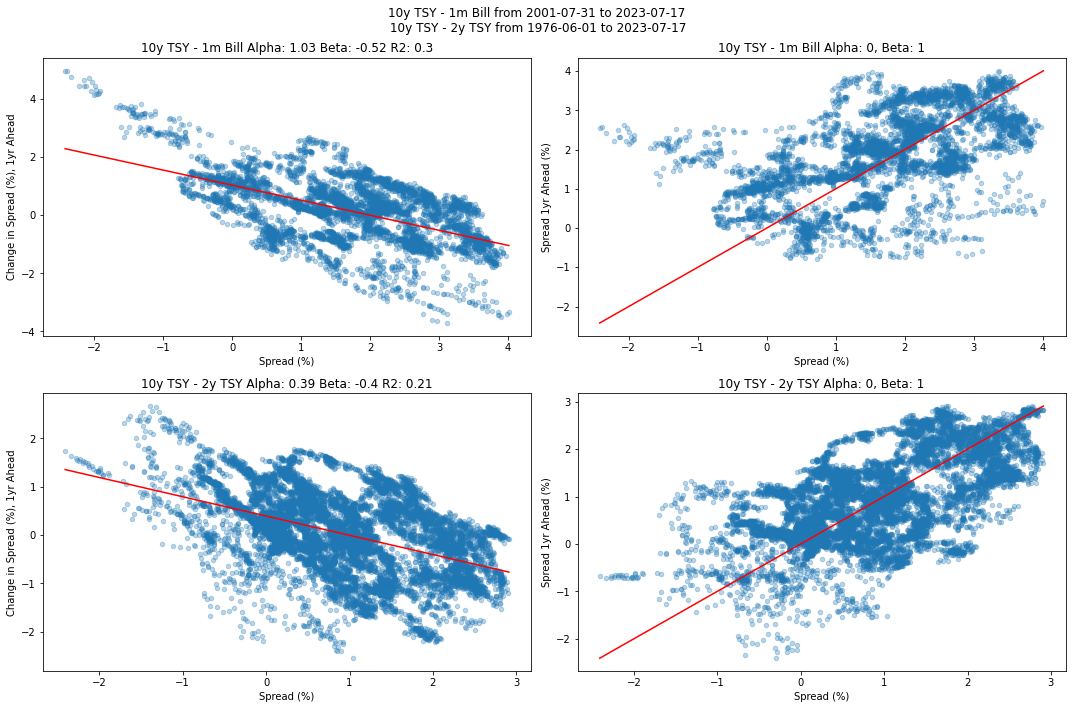

In [11]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
for i, (df_spread, name) in enumerate(zip(spread_list, names)):

    df_tmp = (df_spread.assign(
        spread_change = lambda x: x.spread.shift(252) - x.spread).
        dropna())

    regression1 = (sm.OLS(
        endog = df_tmp.spread_change,
        exog = sm.add_constant(df_tmp.spread)).
        fit())

    alpha1, beta1 = regression1.params
    rsquared1 = regression1.rsquared
    x1 = np.linspace(
        start = df_tmp.spread.min(),
        stop = df_tmp.spread.max(),
        num = 1_000)

    y1 = (beta1 * x1) + alpha1
    axes[i,0].plot(x1, y1, color = "r")

    title = "{} Alpha: {} Beta: {} R2: {}".format(
        name, round(alpha1, 2), round(beta1, 2), round(rsquared1, 2))

    (df_tmp[
        ["spread", "spread_change"]].
        plot(
            ax = axes[i,0],
            kind = "scatter",
            x = "spread",
            y = "spread_change",
            alpha = 0.3,
            xlabel = "Spread (%)",
            ylabel = "Change in Spread (%), 1yr Ahead",
            title = title))

    df_tmp = (df_spread.assign(
        spread_forward = lambda x: x.spread.shift(252)).
        dropna())

    regression2 = (sm.OLS(
        exog = df_tmp.spread_forward,
        endog = sm.add_constant(df_tmp.spread)).
        fit())

    alpha2, beta2 = regression2.params
    title = "{} Alpha: {}, Beta: {}".format(
        name, round(alpha2, 2), round(beta2, 2))

    x2 = np.linspace(
        start = df_tmp.spread.min(),
        stop = df_tmp.spread.max(),
        num = 1_000)
    y2 = (x2 * beta2) + alpha2

    axes[i,1].plot(x2, y2, color = "r")

    (df_tmp.plot(
        ax = axes[i,1],
        kind = "scatter",
        x = "spread",
        y = "spread_forward",
        alpha = 0.3,
        xlabel = "Spread (%)",
        ylabel = "Spread 1yr Ahead (%)",
        title = title))

fig.suptitle("10y TSY - 1m Bill from {} to {}\n 10y TSY - 2y TSY from {} to {}".format(
    spread_list[0].index.min().date(),
    spread_list[0].index.max().date(),
    spread_list[1].index.min().date(),
    spread_list[1].index.max().date()))
plt.tight_layout()

## Running Rolling Regression and Examining Betas to see how far they differ

In [12]:
def spread_rolling_regression(df: pd.DataFrame) -> pd.DataFrame:

    df_tmp = (df.assign(
        forward_spread = lambda x: x.spread.shift(252)).
        dropna())

    regression = (RollingOLS(
        endog = df_tmp.forward_spread,
        exog = sm.add_constant(df_tmp.spread),
        window = 60).
        fit())

    return(regression.params.rename(columns = {
        "const": "alpha",
        "spread": "beta"}))

In [13]:
def get_rolling_forward_beta(df_1m_prep: pd.DataFrame, df_2y_spread: pd.DataFrame) -> pd.DataFrame:

    df_1m_spread_rolling = (spread_rolling_regression(
      df_1m_prep)
      [["beta"]].
      rename(columns = {"beta": "1m_beta"}).
      reset_index())

    df_2y_spread_rolling = (spread_rolling_regression(
        df_2y_prep)
        [["beta"]].
        rename(columns = {"beta": "2y_beta"}).
        reset_index())

    df_spread_rolling = (df_2y_spread_rolling.merge(
        df_1m_spread_rolling,
        how = "outer",
        on = ["Date"]).
        melt(id_vars = "Date").
        dropna().
        pivot(index = "Date", columns = "variable", values = "value").
        rename(columns = {
            "1m_beta": "1m Bill Beta",
            "2y_beta": "2y Tsy Beta"}))

    return df_spread_rolling

In [14]:
def spread_change_rolling_regression(df: pd.DataFrame) -> pd.DataFrame:

    df_tmp = (df.assign(
        forward_spread = lambda x: x.spread.shift(252) - x.spread).
        dropna())

    regression = (RollingOLS(
        endog = df_tmp.forward_spread,
        exog = sm.add_constant(df_tmp.spread),
        window = 60).
        fit())

    return(regression.params.rename(columns = {
        "const": "alpha",
        "spread": "beta"}))

In [15]:
def get_rolling_change_beta(df_1m_prep: pd.DataFrame, df_2y_spread: pd.DataFrame) -> pd.DataFrame:

    df_1m_spread_rolling = (spread_change_rolling_regression(
      df_1m_prep)
      [["beta"]].
      rename(columns = {"beta": "1m_beta"}).
      reset_index())

    df_2y_spread_rolling = (spread_change_rolling_regression(
        df_2y_prep)
        [["beta"]].
        rename(columns = {"beta": "2y_beta"}).
        reset_index())

    df_spread_rolling = (df_2y_spread_rolling.merge(
        df_1m_spread_rolling,
        how = "outer",
        on = ["Date"]).
        melt(id_vars = "Date").
        dropna().
        pivot(index = "Date", columns = "variable", values = "value").
        rename(columns = {
            "1m_beta": "1m Bill Beta",
            "2y_beta": "2y Tsy Beta"}))

    return df_spread_rolling

In [16]:
df_spread_rolling = get_rolling_forward_beta(df_1m_prep, df_2y_prep)
df_change_rolling = get_rolling_change_beta(df_1m_prep, df_2y_prep)

rolling_beta_list = [df_spread_rolling, df_change_rolling]
rolling_beta_names = ["Forward Spread", "Change in Spread"]

In [17]:
def _get_stats(df: pd.DataFrame) -> pd.DataFrame:

    return(pd.DataFrame({
        "kurtosis": [df.value.kurtosis()],
        "std": [df.value.std()]}))

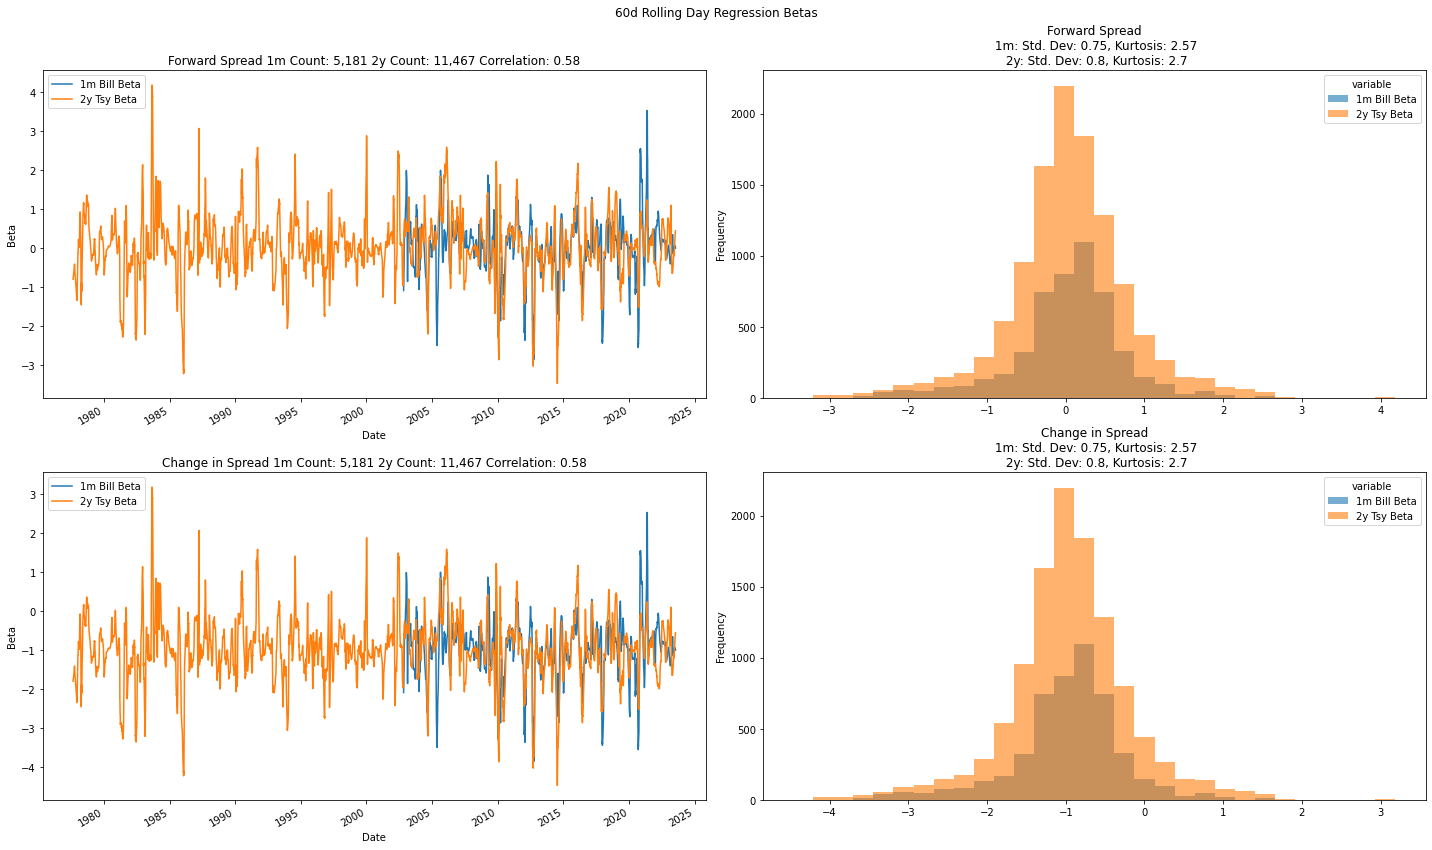

In [18]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 12))

for i, (beta_df, name) in enumerate(zip(rolling_beta_list, rolling_beta_names)):

    df_count = (beta_df.reset_index().melt(
        id_vars = "Date").
        dropna()
        [["variable", "value"]].
        groupby("variable").
        agg("count"))

    df_stats = (beta_df.reset_index().melt(
        id_vars = "Date").
        dropna().
        groupby("variable").
        apply(_get_stats).
        reset_index())

    correlation = beta_df.dropna().corr()[beta_df.columns[1]].iloc[0]

    title = name + " 1m Count: {:,} 2y Count: {:,} Correlation: {}".format(
            df_count.value.iloc[0],
            df_count.value.iloc[1],
            round(correlation, 2))

    (beta_df.plot(
        ax = axes[i, 0],
        title = title,
        ylabel = "Beta"))

    title = name + "\n 1m: Std. Dev: {}, Kurtosis: {}\n 2y: Std. Dev: {}, Kurtosis: {}".format(
        round(df_stats["std"].iloc[0], 2),
        round(df_stats["kurtosis"].iloc[0], 2),
        round(df_stats["std"].iloc[1], 2),
        round(df_stats["kurtosis"].iloc[1], 2))

    (beta_df.plot(
        ax = axes[i,1],
        kind = "hist",
        alpha = 0.6,
        bins = 30,
        title = title,
        xlabel = "Beta"))

    axes[i,0].legend(loc = "upper left")
    fig.suptitle("60d Rolling Day Regression Betas")

    plt.tight_layout()

## Analyzing Yields based on Inversion

In [19]:
spread_list = [df_1m_prep, df_2y_prep]

In [20]:
def _shift(df: pd.DataFrame) -> pd.DataFrame:
    return(df.assign(
        shift_ = lambda x: x.value.shift(252)).
        dropna())

def get_inverted_change(df: pd.DataFrame) -> pd.DataFrame:

    df_spread = df[["spread"]].reset_index()

    df_tmp = (df.drop(
        columns = ["spread"]).
        reset_index().
        melt(id_vars = "Date").
        groupby("variable").
        apply(_shift).
        assign(change = lambda x: x.shift_ - x.value)
        [["Date", "variable", "change"]].
        pivot(index = "Date", columns = "variable", values = "change").
        reset_index())

    df_combined = (df_tmp.merge(
        df_spread, how = "inner", on = ["Date"]).
        query("spread < 0"))

    return df_combined

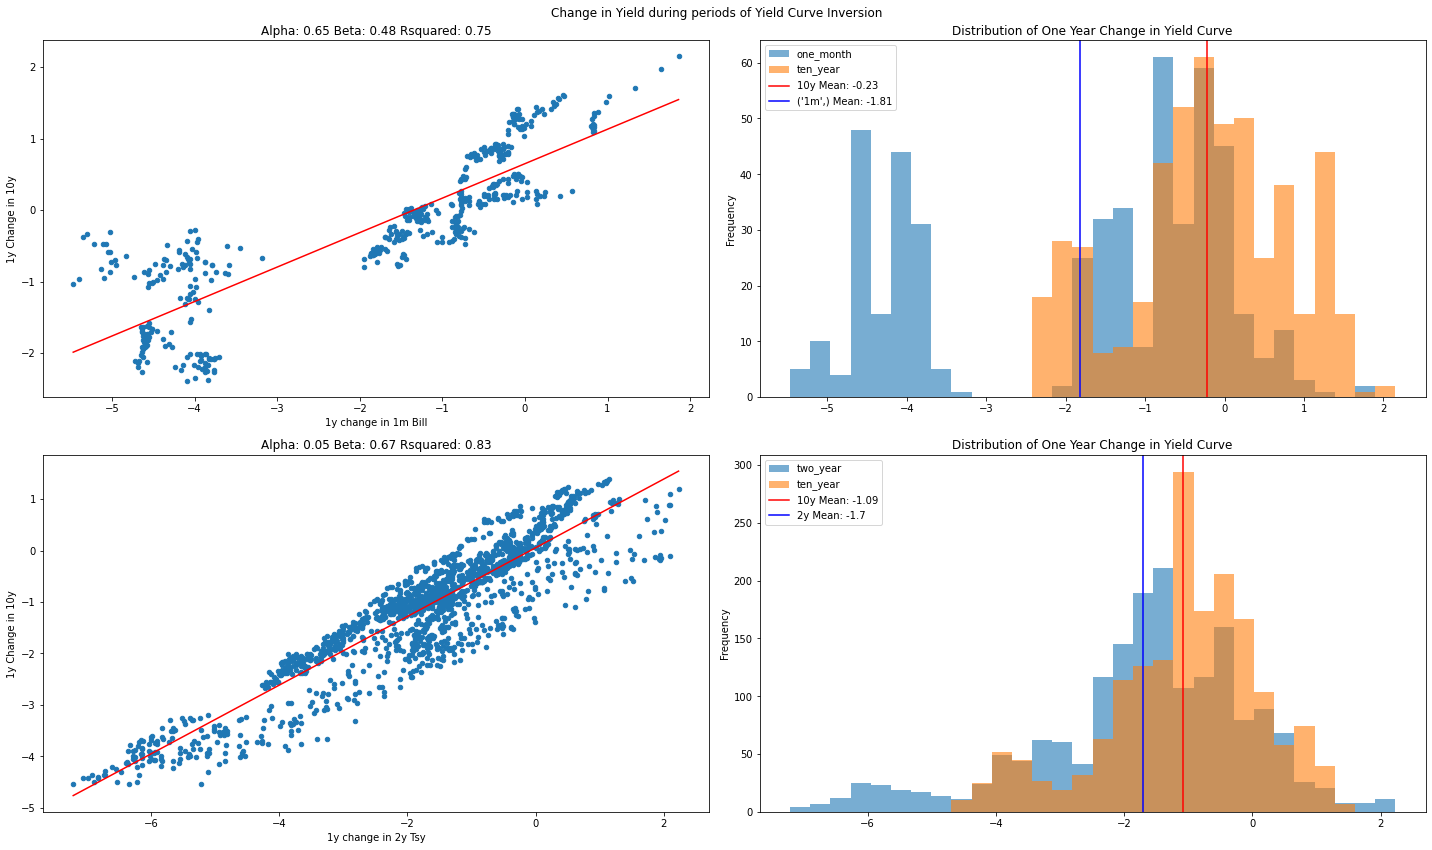

In [21]:
inverted_dfs = [df_1m_prep, df_2y_prep]
x_value_list = ["one_month", "two_year"]
names_list = ["1m Bill vs. 10y Tsy", "2y Tsy vs. 10y Tsy"]

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 12))
for i, (inverted_df, name, x_value) in enumerate(zip(inverted_dfs, names_list, x_value_list)):

    df_tmp = get_inverted_change(inverted_df)
    if x_value == "one_month": xlabel = "1y change in 1m Bill"
    else: xlabel = "1y change in 2y Tsy"

    regression = (sm.OLS(
        endog = df_tmp["ten_year"],
        exog = sm.add_constant(df_tmp[x_value])).
        fit())

    alpha, beta = regression.params
    rsquared = regression.rsquared

    x = np.linspace(
        start = df_tmp[x_value].min(),
        stop = df_tmp[x_value].max(),
        num = 1_000)

    y = (x * beta) + alpha
    axes[i,0].plot(x, y, color = "r")

    (df_tmp.plot(
        kind = "scatter", x = x_value, y = "ten_year",
        ax = axes[i, 0],
        xlabel = xlabel,
        ylabel = "1y Change in 10y",
        title = "Alpha: {} Beta: {} Rsquared: {}".format(
            round(alpha, 2),
            round(beta, 2),
            round(rsquared, 2))))

    (df_tmp[
        [x_value, "ten_year"]].
        plot(
            kind = "hist",
            ax = axes[i,1],
            bins = 30,
            alpha = 0.6,
            xlabel = "change in yield",
            title = "Distribution of One Year Change in Yield Curve"))

    ten_year_mean = df_tmp["ten_year"].mean()
    other_year_mean = df_tmp[x_value].mean()

    if x_value == "one_month": legend_label = "1m",
    else: legend_label = "2y"

    axes[i,1].axvline(
        x = ten_year_mean, color = "red",
        label = "10y Mean: {}".format(round(ten_year_mean, 2)))

    axes[i,1].axvline(
        x = other_year_mean, color = "blue",
        label = "{} Mean: {}".format(legend_label, round(other_year_mean, 2)))

    axes[i,1].legend(loc = "upper left")

fig.suptitle("Change in Yield during periods of Yield Curve Inversion")
plt.tight_layout()
plt.show()